## TDMClient Functions

In [1]:
import tdmclient.notebook
import time
#fonctions de Julie 
@tdmclient.notebook.sync_var 
def set_speed(right_speed,left_speed):
    global motor_right_target, motor_left_target
    motor_right_target=right_speed
    motor_left_target=left_speed

@tdmclient.notebook.sync_var
def stop_thymio():
    global motor_right_target,motor_left_target
    motor_right_target=0
    motor_left_target=0

@tdmclient.notebook.sync_var
def get_speed():
    global motor_right_speed, motor_left_speed
    return motor_right_speed,motor_left_speed

def speed_convesion(r_speed,l_speed):
    thymio_speed_to_mms = 0.4375 # value found in covariance_estimation

    #odometry 
    avg_thymio_speed = (r_speed + l_speed) / 2
    speed = avg_thymio_speed * thymio_speed_to_mms # [mm/s]
    return speed

def angular_vel_conversion(r_speed,l_speed):
    d = 95 # distance between the 2 wheels [mm]
    thymio_speed_to_mms = 0.4375 # value found in covariance_estimation
    
    difference_speed = l_speed - r_speed
    omega = difference_speed * thymio_speed_to_mms / d # [rad/s]

    return omega

@tdmclient.notebook.sync_var
def get_proximity_values():
    global prox_horizontal
    prox = prox_horizontal
    prox_front = prox[2]
    prox_left = prox[0]
    prox_left_front = prox[1]
    prox_right_front = prox[3]
    prox_right = prox[4]
    return prox_front, prox_left, prox_left_front, prox_right_front, prox_right

def avoid_obstacle(decision="right"):
    """
    Perform a simplified L-shaped maneuver for obstacle avoidance using time.sleep.
    Args:
        decision (str): Turning direction ("right" or "left").
    """
    print("Starting obstacle avoidance maneuver...")

    # Phase 1: Turn away from the obstacle
    print(f"Phase 1: Turning {decision} away from the obstacle.")
    if decision == "right":
        set_speed(-100, 100)  # Turn right
    elif decision == "left":
        set_speed(100, -100)  # Turn left
    time.sleep(2)  

    # Phase 2: Move forward to clear the obstacle
    print("Phase 2: Moving forward to clear the obstacle.")
    set_speed(100, 100)  
    time.sleep(2.5)  

    # Phase 3: Turn back to original direction
    print(f"Phase 3: Returning to original direction (opposite of {decision}).")
    if decision == "right":
        set_speed(100, -100)  # Turn left
    elif decision == "left":
        set_speed(-100, 100)  # Turn right
    time.sleep(2)  

    # Stop the robot
    stop_thymio()
    print("Obstacle avoidance completed.")


## remove

In [2]:
import matplotlib.pyplot as plt
import numpy as np


def speed_convesion(r_speed,l_speed):
    thymio_speed_to_mms = 0.430 # value found in covariance_estimation

    #odometry 
    avg_thymio_speed = (r_speed + l_speed) / 2
    speed = avg_thymio_speed * thymio_speed_to_mms # [mm/s]
    return speed

def angular_vel_conversion(r_speed,l_speed):
    d = 95 # distance between the 2 wheels [mm]
    thymio_speed_to_mms = 0.430 # value found in covariance_estimation
    
    difference_speed = l_speed - r_speed
    omega = difference_speed * thymio_speed_to_mms / d # [rad/s]

    return omega
print()

In [3]:
state_est_prev=[0,0,0,0,0]
P_prev=np.diag([0.1,0.1,0.1,0.1,0.1])

obs_camera=[np.nan,np.nan,np.nan]

camera_state=False


# faire une boucle ici
actual_v=speed_convesion(get_speed())
actual_w=angular_vel_conversion(get_speed())
obs_odometry=np.concatenate((actual_v,actual_w))

input_v=speed_convesion(r_speed,l_speed)
input_w=angular_vel_conversion(r_speed,l_speed)
control_vect_prev=np.concatenate((input_v,input_w))


state_est, P_est = ekf(state_est_prev, control_vect_prev, P_prev, obs_camera, obs_odometry, camera_state)

state_est_prev=state_est
P_prev=P_est

AttributeError: 'NoneType' object has no attribute 'var'

## Robot Demo!
----

Imports from each module:

In [5]:
import Modules.Control as Control
import matplotlib.pyplot as plt
import Modules.Path_planning as Path_planning
import tdmclient.notebook
import Modules.ThymioCommands as ThymioCommands
import Modules.LocalNav as LocalNav
import time
import numpy as np
import Modules.Kalman as Kalman
from Modules.ThymioVision import ThymioVision # Computer vision package

Begin the thymio, calibrate for demo

In [2]:
await tdmclient.notebook.start()

In [3]:
global leds_circle
leds_circle=[32,32,0,0,0,0,0,32] # Turn on thymio lights for tracking

In [5]:
await tdmclient.notebook.stop()

Calibrate Camera, Detect Edges, Thymio Position, and Goal.

2024-12-04 19:13:21.172 Python[41576:1667227] WARNING: AVCaptureDeviceTypeExternal is deprecated for Continuity Cameras. Please use AVCaptureDeviceTypeContinuityCamera and add NSCameraUseContinuityCameraDeviceType to your Info.plist.


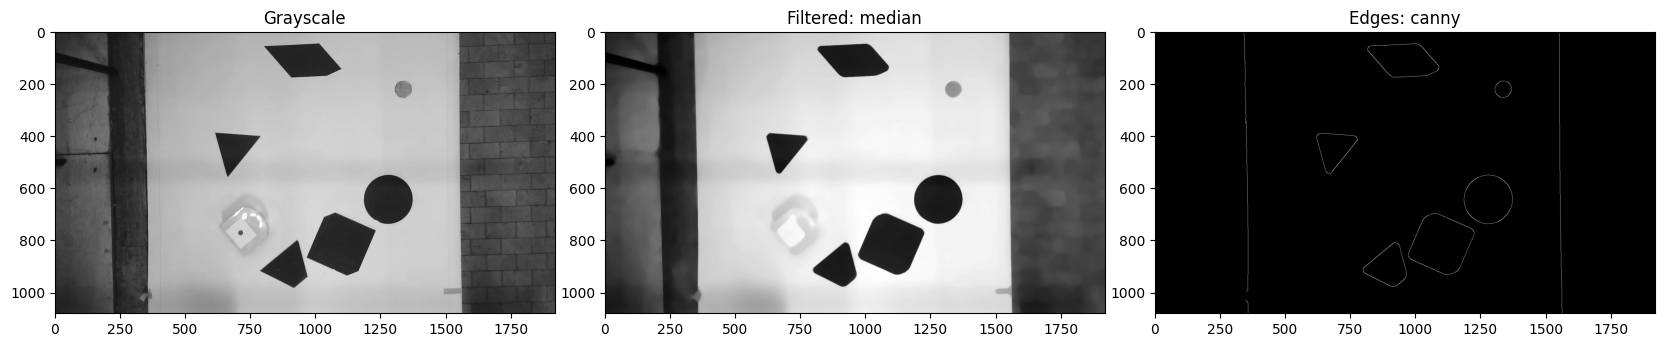

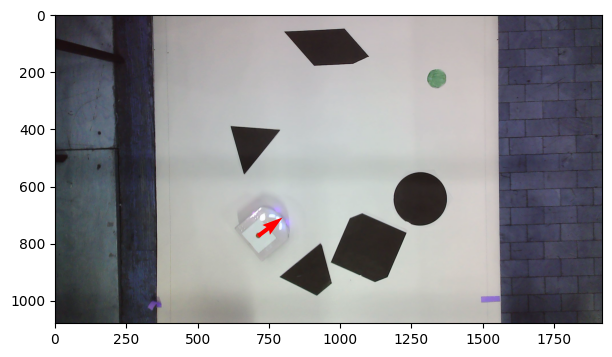

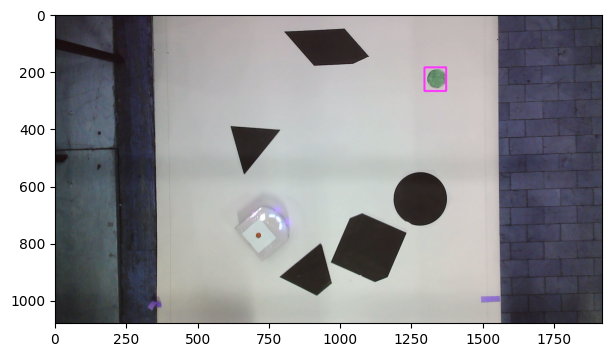

In [6]:
ThymioVision.calibrateCameraPos(0) #Calibrate the corners to the map.
frame = ThymioVision.captureImageOnCommand(0) # Capture the image to define the map
edges = ThymioVision.getEdges(frame, verbose=True)
start = ThymioVision.getThymioPose(frame, verbose=True)
end = ThymioVision.detectGoal(frame, verbose=True)

Display the map

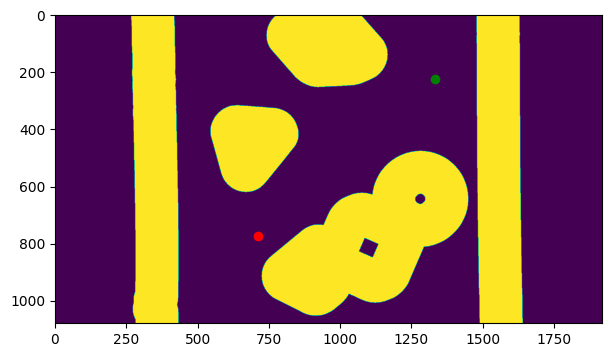

In [7]:
map = ThymioVision.getMap(frame, verbose=True)

In [8]:
# Define the inputs for the path_planning module
obstacles = map[0]
start = map[1]
end = map[2]
# adjusting x/y to row/col -> flip them.
correctedStart = [start[1], start[0]]
correctedGoal = [end[1], end[0]]

# Determine best path from map
path = Path_planning.A_star(obstacles, correctedStart, correctedGoal)

Path found: [[773, 713], [772, 714], [771, 715], [770, 716], [769, 717], [768, 718], [767, 719], [766, 720], [765, 721], [764, 722], [763, 723], [762, 724], [761, 725], [760, 726], [759, 727], [758, 728], [757, 729], [756, 730], [756, 731], [755, 732], [754, 733], [753, 734], [752, 735], [751, 736], [750, 737], [749, 738], [748, 739], [747, 740], [746, 741], [745, 742], [744, 743], [743, 744], [742, 745], [741, 746], [740, 747], [739, 748], [738, 749], [737, 750], [736, 751], [735, 752], [734, 753], [733, 754], [732, 755], [731, 756], [730, 757], [729, 758], [728, 759], [727, 760], [726, 761], [725, 762], [724, 763], [723, 764], [722, 765], [721, 766], [720, 767], [719, 768], [718, 769], [717, 770], [716, 771], [715, 772], [714, 773], [713, 774], [712, 775], [711, 776], [710, 777], [709, 778], [708, 779], [708, 780], [707, 781], [706, 782], [705, 783], [704, 784], [703, 785], [702, 786], [701, 787], [700, 788], [699, 789], [698, 790], [697, 791], [696, 792], [695, 793], [694, 794], [69

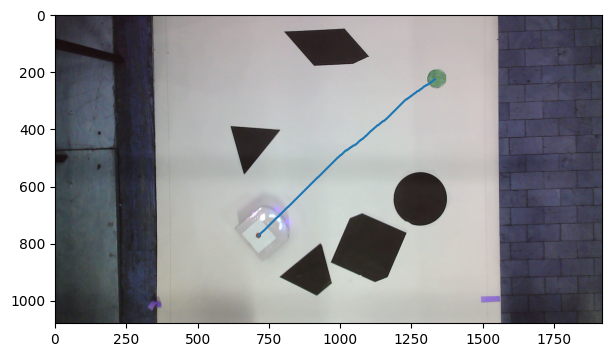

In [9]:
# Break the path into waypoints that the Thymio can follow.
# Swap back to pixel coordinates
swapped = Path_planning.swap_path_coordinates(path)
waypoints = []
for point in swapped:
    x, y = ThymioVision.pixelToRealSpace(point)
    waypoints.append((x*10, y*10)) #convert to mm!
waypoints = Control.segment_path(waypoints, step=40)

lx = []
ly = []
for wp in path:
    lx.append(wp[0])
    ly.append(wp[1])

# Display path on frame
plt.imshow(frame)
plt.plot(ly, lx)
plt.show()

Main Movement Loop!

In [10]:
import cv2
cv2.namedWindow("Camera view")
vc=cv2.VideoCapture(0)
print("vc captured")

# Initial state [x, y, theta]

###################### INITIALIZE STATE FROM MAP READ ######################

obstSpeedGain = [2, 1, -1, -1.5, -2.5]  # Gains for obstacle avoidance
OBSTACLE_THRESH_LOW_FRONT = 8 # Threshold to stop avoiding
OBSTACLE_THRESH_HIGH_FRONT = 30 # Threshold to start avoiding
thymio_state = 0  # 0 = Goal tracking, 1 = Obstacle avoidance

state_est=[0,0,0,0,0] 
ret,frame=vc.read()
if ret:
    pose = ThymioVision.getThymioPose(frame) #pixel location of thymio
    obs_camera = ThymioVision.pixelToRealSpace(pose[0:2]) #returns cm, *10 to get mm
    obs_camera = (obs_camera[0]*10, obs_camera[1]*10, pose[2]) #thymio position in mm to give to kalman filter
    state_est=[obs_camera[0],obs_camera[1],obs_camera[2],0,0]   
P_est=np.diag([0.1,0.1,0.1,0.1,0.1])
goal_tolerance = 30


###################### LOGGING DATA ######################
trajectory = []  # To store [x, y] positions
trajectory.append(obs_camera[0:2])
camera_trajectory = [] #trajectory mapped by camera
trajectory = []  # Logs (x, y) positions
metrics_rho = []  # Logs for distance to goal
metrics_alpha = []  # Logs for angle to goal
time_prev = time.time()

###################### BEGIN MOTION LOOP ######################
while len(waypoints) > 0: # while we have goals in life
    actual_time = time.time()
    Ts = actual_time - time_prev
    if Ts < 0.15:
        time.sleep(0.15-Ts)
    time_prev = actual_time

    waypoint = waypoints[0] # current goal

    ################### SENSOR READS ###################
    ret,frame=vc.read()
    if ret:
        pose = ThymioVision.getThymioPose(frame)#pixel location of thymio
        if pose[0] is not None:
            obs_camera = ThymioVision.pixelToRealSpace(pose[0:2]) #returns cm, *10 to get mm
            obs_camera = (obs_camera[0]*10, obs_camera[1]*10, pose[2]) #thymio position in mm to give to kalman filter
            camera_trajectory.append(obs_camera) #position in mm appended to log
            cv2.circle(frame, (pose[0:2]), 3, (0,255,255),-1) #camera pos
            # convert trajectory onto map
        if len(trajectory) > 0:
            lastPos = trajectory[-1]
            lastPos = (lastPos[0]/10, lastPos[1]/10)
            pixelPred = ThymioVision.realSpaceToPixel(lastPos)
            cv2.circle(frame, (pixelPred), 3, (0,255,0),-1) #est pos
        cv2.imshow("Camera view", frame)
        key = cv2.waitKey(50)
    if key == ord('q'):
        break
    if not ret or pose[0] is None:
        camera_state=False
    else:
        camera_state=True
    print(camera_state)

    prox_front, prox_left, prox_left_front, prox_right_front, prox_right = get_proximity_values()
    proximity_values = [prox_left, prox_left_front, prox_front, prox_right_front, prox_right]

    ###################### CHECK THYMIO STATE ######################

    # Check for obstacle state transitions
    if thymio_state == 0:
        # Switch to obstacle avoidance if an obstacle is detected
        if any((prox // 100) > OBSTACLE_THRESH_HIGH_FRONT for prox in proximity_values) :
            thymio_state = 1
        elif len(trajectory) >= 1 and ((obs_camera[0]-trajectory[-1][0])**2 + (obs_camera[1]-trajectory[-1][1])**2) > 500:
            print(obs_camera)
            print(trajectory[-1])
            # if change between states is too rapid, we have been kidnapped. recalculate and attempt again
            thymio_state = 2
            continue
    elif thymio_state == 1:
    # Switch back to goal tracking if obstacles are cleared
        if all((prox // 100) < OBSTACLE_THRESH_LOW_FRONT for prox in proximity_values):
            print("Obstacle avoided")
            #set_speed(20, 20)  #Continue getting away from obstacle for a short time ?   
            #stop_thymio() #idk if i keep it 
            thymio_state = 2 # set state to "kidnapped." Will recalculate the path and continue.

    ###################### GLOBAL NAVIGATION ######################
    if thymio_state == 0:
        print("Global Nav")
        # input_left_speed, input_right_speed, reached , v_f , omega_f  = Control.move_to_waypoint(state_est, waypoint, goal_tolerance)
        # input_left_speed, input_right_speed, reached , v_f , omega_f  = Control.move_to_waypoint(obs_camera, waypoint, goal_tolerance)
        if not camera_state:
            input_left_speed, input_right_speed, reached , v_f , omega_f  = Control.move_to_waypoint(state_est, waypoint, goal_tolerance*2)
            set_speed(int(input_right_speed/2), int(input_left_speed/2))
        else:
            input_left_speed, input_right_speed, reached , v_f , omega_f  = Control.move_to_waypoint(state_est, waypoint, goal_tolerance)
            set_speed(input_right_speed, input_left_speed)
    ###################### LOCAL NAVIGATION ######################   
    elif thymio_state == 1:
        print("Avoidance")
        decision, left_dist, right_dist = LocalNav.check_sides(state_est[0:3], obstacles)
        print(f"Turning decision: {decision}, Left Distance: {left_dist}, Right Distance: {right_dist}")
        avoid_obstacle(decision)  
        thymio_state = 0
        continue
    ###################### KIDNAPPING RECALCULATION ###################### 
    else:
        print("Kidnapped") ##TODO FIX NO PATH FOUND ERROR
        # stop the thymio
        input_left_speed, input_right_speed, reached , v_f , omega_f = 0, 0, False, 0, 0
        set_speed(input_right_speed, input_left_speed)
        #if the camera is reading, update the path
        if camera_state:
            # convert trajectory onto map
            if len(trajectory) > 0:
                lastPos = trajectory[-1]
                lastPos = (lastPos[0]/10, lastPos[1]/10)
                pixelPred = ThymioVision.realSpaceToPixel(lastPos)
                cv2.circle(frame, (pixelPred), 3, (0,255,0),-1) #est pos
            cv2.imshow("Camera view", frame)
            path = None
            while not path:
                ret,frame=vc.read()
                if ret:
                    pose = ThymioVision.getThymioPose(frame)#pixel location of thymio
                    path = Path_planning.A_star(obstacles, (pose[1],pose[0]), correctedGoal)
            swapped = Path_planning.swap_path_coordinates(path)
            waypoints = []
            for point in swapped:
                x, y = ThymioVision.pixelToRealSpace(point)
                waypoints.append((x*10, y*10)) #convert to mm!
            waypoints = Control.segment_path(waypoints, step=40)
            trajectory.append(obs_camera[0:2]) #append most recent location
            thymio_state = 0 # go back to global nav

        
    ################### UPDATE STATE ESTIMATE ###################

    # Control input
    input_v = v_f #Ca jsp si je remplace par actual_v et actual_w
    input_w = omega_f
    control_vect_prev = [input_v, input_w]
    
    r_speed_odo, l_speed_odo = get_speed()
    actual_v = speed_convesion(r_speed_odo, l_speed_odo)
    actual_w = angular_vel_conversion(r_speed_odo, l_speed_odo)
    obs_odometry = [actual_v, actual_w]

    # Update state with Kalman filter
    state_est, P_est = Kalman.ekf(state_est, control_vect_prev, P_est, obs_camera, obs_odometry, camera_state,Ts)
    state_est[2]=Control.normalize_angle(state_est[2])
    # Log trajectory
    trajectory.append((state_est[0], state_est[1]))
    
    # Calculate and log metrics
    rho = np.sqrt((waypoint[0] - state_est[0])**2 + (waypoint[1] - state_est[1])**2)
    alpha = Control.normalize_angle(np.arctan2(waypoint[1] - state_est[1], waypoint[0] - state_est[0]) - state_est[2])
    metrics_rho.append(rho)
    metrics_alpha.append(alpha)
    
    # Print updated state
    # print(ThymioVision.pixelToRealSpace(pose[0:2]))
    print(f"Position Actuelle camera  : x = {obs_camera[0]}, y = {obs_camera[1]}, theta = {obs_camera[2]}") 
    print(f"Position Actuelle odometry: x = {state_est[0]}, y = {state_est[1]}, theta = {state_est[2]}") 

    if reached:
        waypoints.pop(0)
        print(f"Reached waypoint: {waypoint}")
        # Stop the robot at the waypoint
        stop_thymio()

vc.release()
stop_thymio()
cv2.destroyAllWindows()
print("Trajectory completed!")


vc captured
True
Global Nav
Position Actuelle camera  : x = 264.75, y = 512.25, theta = 0.6549948555083149
Position Actuelle odometry: x = 264.75, y = 512.25, theta = 0.6551233391146312
Reached waypoint: (264.75, 512.25)
True
Global Nav
Position Actuelle camera  : x = 264.75, y = 512.25, theta = 0.711459125739508
Position Actuelle odometry: x = 264.7449719364604, y = 512.2461368369372, theta = 0.705714411330316
True
Global Nav
Position Actuelle camera  : x = 264.75, y = 512.25, theta = 0.6711438354360088
Position Actuelle odometry: x = 264.75972305542945, y = 512.2579636406499, theta = 0.6747167516542203


2024-12-04 19:13:35.668 Python[41576:1667227] +[IMKClient subclass]: chose IMKClient_Legacy
2024-12-04 19:13:35.668 Python[41576:1667227] +[IMKInputSession subclass]: chose IMKInputSession_Legacy


True
Global Nav
Position Actuelle camera  : x = 266.25, y = 510.75, theta = 0.6502274647484393
Position Actuelle odometry: x = 266.22949930822864, y = 510.79158747431893, theta = 0.6439600777520074
True
Global Nav
Position Actuelle camera  : x = 270.75, y = 507.75, theta = 0.6620604624977243
Position Actuelle odometry: x = 270.7324328619035, y = 507.8174461065461, theta = 0.6267012999524972
True
Global Nav
Position Actuelle camera  : x = 275.25, y = 504.75, theta = 0.6873528861036091
Position Actuelle odometry: x = 275.22779539742095, y = 504.8236104564004, theta = 0.648917075639857
True
Global Nav
Position Actuelle camera  : x = 281.25, y = 500.25, theta = 0.7276113326265107
Position Actuelle odometry: x = 281.2163137139252, y = 500.3453091721503, theta = 0.6740431413897587
Reached waypoint: (294.75, 483.0)
True
Global Nav
Position Actuelle camera  : x = 284.25, y = 495.75, theta = 0.7447701257160751
Position Actuelle odometry: x = 284.1831356071134, y = 495.84605348008034, theta = 0.

KeyboardInterrupt: 

In [16]:
stop_thymio()

TypeError: list indices must be integers or slices, not tuple